# Analysis of results of running the OpenCL RAMP model with dynamic calibration of the model parameters

The OpenCL RAMP model is ran with ABC in RunModel_DynamicCalibration.py. The prior distribution of parameters driving the model are based on past knowledge of similar epidemics. The model is run initially for a 14 day window in which the parameters are calibrated using ABC with 5 populations and 100 particles in each population. The posterior parameter distributions are then used as the input to the second window, which then runs for 28 days, with the parameters again being calibrated using ABC with 5 populations and 100 particles. This process of feeding the posteriors back in as the prior in the subsequent window is repeated with the window length increasing by 14 days each time, up until 8 windows have been run, with the final window having a length of 98 days.

This notebook compares the performance of the OpenCL RAMP model ran with dynamic calibration, with the performance of the same model, but ran with one-off calibration of the parameter values. 

For the dynamic calibration, the model is ran in RunModel_DynamicCalibration.py. For each window, a .pkl file is saved which contains the history object for that window. This can be queried to extract the associated parameter values and weights. For the one-off calibration, the model is ran in RunModel_OneShotCalibration.py, and similarly produces a .pkl file which can be queried.

In both cases, the current risk beta value which controls the general transmissability of the disease is set as a constant using the value determined in InitialModelCalibration.ipynb

The following aspects of the model performance are examined:
1. The evolution of the parameter values with dynamic calibration over the course of the pandemic
2. The predictions made by the model within each calibration window
3. The predictions made when the parameter values from the final dynamic calibration window are used to run the model forward in time for 105 days.

For 3. the performance of the model using the parameters from the dynamic calibration process at the end of each window are compared to the performance of the model using parameter values from a one-off model calibration. For each dynamic calibration window, the model using parameter values from a one-off model calibration being used for comparison has been calibrated using the same number of days of data as the length of that dynamic calibration window. 

### Set up environment and read in data

#### Set up environment

In [1]:
import pickle
import os
import pyabc
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import pandas as pd
import sys
import matplotlib.patches as mpatches   

# Bespoke RAMP classes for running the model
sys.path.append("../../")
# from opencl_runner import OpenCLWrapper  # Some additional functions to simplify running the OpenCL model
from opencl_runner import OpenCLRunner

from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior


#### Read in history.pkl objects

In [2]:
history_dict = {}
windows  =8
for window in range(1,windows+1):
    fname = "Outputs/RunModel_DynamicCalibration/abc_history_8windows_window{}, 5pops_100particles_Crb0.019_1656078569.pkl".format(window)
    with open(fname, "rb") as f:
            history = pickle.load(f)
    history_dict["w{}".format(window)]= history 

#### Read in observations data

In [3]:
# Read in daily devon case data (interpolated from weekly)
cases_devon_daily = pd.read_csv("observation_data/daily_cases_devon.csv")
# Add column with cumulative sums rather than cases per day
cases_devon_daily['CumulativeCases'] = cases_devon_daily['OriginalCases'].cumsum()
# Keep just cumulative cases
cases_devon_daily = cases_devon_daily['CumulativeCases'].values
    
## Get dataframe with totals for whole of Devon
cases_devon_weekly = pd.read_csv("observation_data/weekly_cases_devon.csv")
# Add column with cumulative sums rather than cases per week
cases_devon_weekly['CumulativeCases'] = cases_devon_weekly['OriginalCases'].cumsum()
# Keep just cumulative cases
cases_devon_weekly = cases_devon_weekly['CumulativeCases'].values

# Convert this interpolated data used in seeding back to weekly
# List the index matching the end day of each week (e.g. 7, 14, 21 etc (minus 1 for indexing starting at 0)
n_days = len(cases_devon_daily)
week_end_days = list(range(6,n_days+1,7))

# Keep only the values from the end of each week
cases_devon_daily_summed_weekly = cases_devon_daily[week_end_days]

#### Define prior parameter values

In [4]:
retail_rv, primary_school_rv, secondary_school_rv = (pyabc.RV("uniform", 0, 1) for _ in range(3))
work_rv = pyabc.RV("beta", 0.1, 2)
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = (pyabc.RV("norm", 0.444, 0.155) for _ in range(3))

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = {"retail": retail_rv, "primary_school": primary_school_rv, "secondary_school": secondary_school_rv, "work": work_rv,
    "presymptomatic": presymptomatic_rv, "symptomatic": symptomatic_rv, "asymptomatic": asymptomatic_rv}

## Create a distrubtion from these random variables
decorated_rvs = {name: pyabc.LowerBoundDecorator(rv, 0.0) for name, rv in all_rv.items()}

# Define the original priors
original_priors = pyabc.Distribution(**decorated_rvs)

## 1. The evolution of the parameter values with dynamic calibration over the course of the pandemic

### Prior distribution of each parameter, and the posterior distribution at the end of each window (final population)

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ramp-ua-min/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


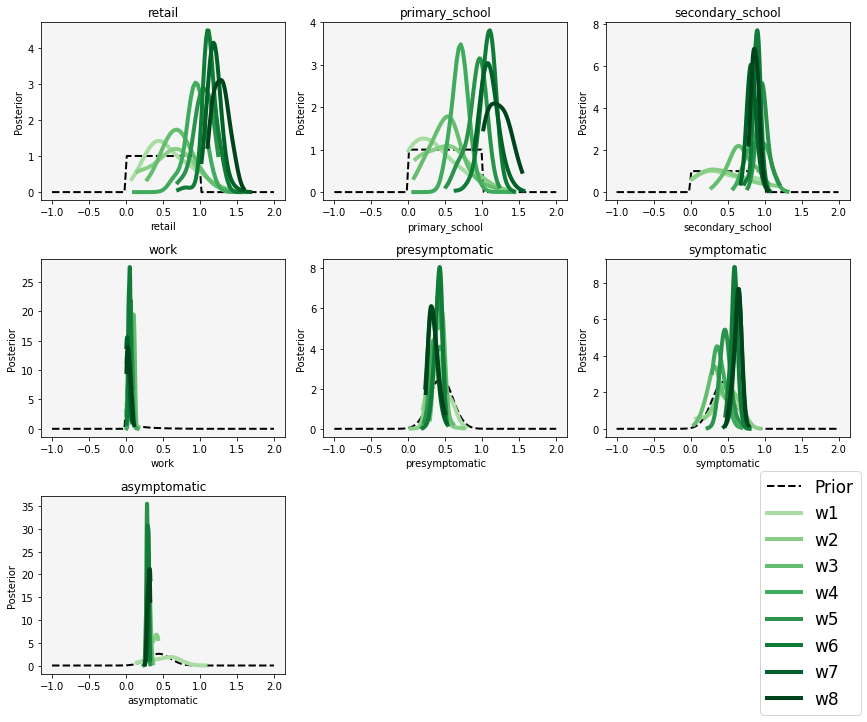

In [5]:
# Define colour map
evenly_spaced_interval = np.linspace(0.35, 1, len(history_dict))
colors = [cm.Greens(x) for x in evenly_spaced_interval]

# Set up plot
fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
# Loop through each parameter, and add a subplot
for i, param in enumerate(original_priors.keys()):
    ax = axes.flat[i]
    ax.set_facecolor('whitesmoke')
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 2, linestyle ='dashed')
    # Loop through each window and plot the posterior distribution from the final population
    for count, (history_name, history) in enumerate(history_dict.items()):
        df, w = history.get_distribution(m=0, t=history.max_t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, label=history_name, linewidth = 4, 
                                        color= colors[count])
        ax.legend(fontsize="small")
        ax.set_title(f"{param}")
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
# Add legend        
fig.legend(handles, labels, loc='center right', fontsize = 17, bbox_to_anchor=(1.01, 0.17))
# Formatting
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()

### Prior distribution of each parameter, and the posterior distribution at the end of each window (final population), with the distributions for the intermediate populations as dashed lines

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ramp-ua-min/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


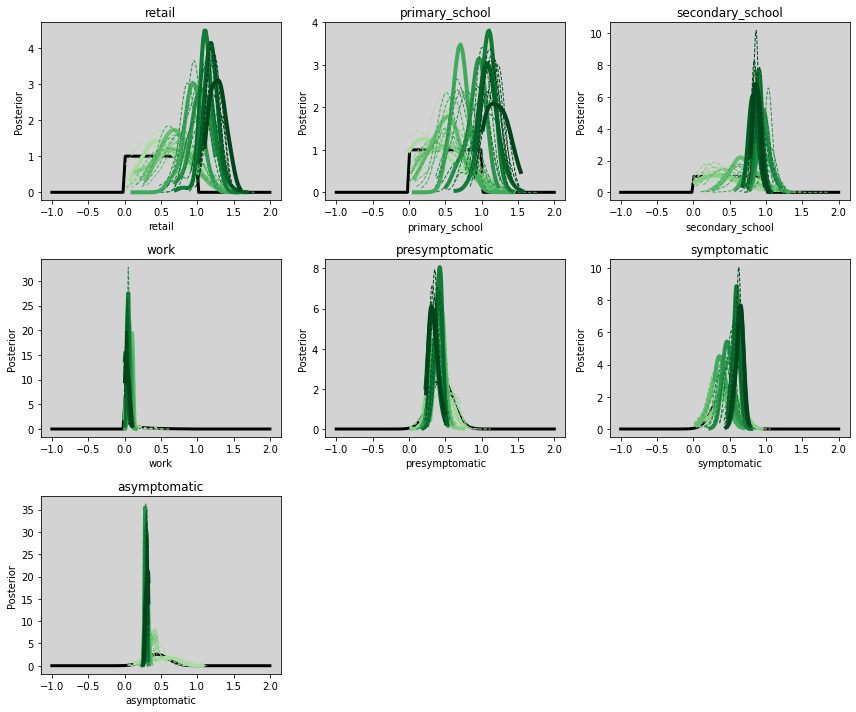

In [6]:
# Define colour map and line style to use in intermediate populations
linestyles = ['dashed'] * history.max_t + ['solid']
linewidths = [1] * history.max_t + [4]

# Set up plot
fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
# Loop through each parameter
for i, param in enumerate(original_priors.keys()):
    ax = axes.flat[i]
    ax.set_facecolor('lightgray')
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 3, linestyle ='solid')
    # Loop through each window
    for count, (history_name, history) in enumerate(history_dict.items()):
        # Loop through each population
        for t in range(history.max_t + 1):
            df, w = history.get_distribution(m=0, t=t)
            pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                label="{}, pop {}".format(history_name, t),
                color = colors[count], linestyle = linestyles[t],linewidth = linewidths[t])
            ax.legend(fontsize="small")
            ax.set_title(f"{param}")
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()
# Formatting        
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()

## 2. Assessment of the predictions made by the model within each calibration window

##### Get the model predictions and particle distances for each particle within each dynamic calibration window. Store these in a dictionary

In [7]:
# Create dictionary linking each window name to its length (days)
window_lengths_dict = {}
for count, key in enumerate(history_dict.keys()):
    window_lengths_dict[key]=14*(count+1)

# Create dictionary to store results for each window
abc_sum_stats = {}

# Loop through each calibration window, defining the number of days it covered
for t in range(0,history.n_populations):
    for window, n_days in window_lengths_dict.items():

        # Create lists to store values for each particle
        distance_l, daily_preds_l, params_l = [],[],[]

        # get the history for this window    
        history_wx  = history_dict[window]   

        # Get parameter values
        parameter_vals_df, w = history_wx.get_distribution(m=0, t=t)

        # Get the summary stats for the final population for this window ([1] means keep just the 
        # dataframe and not the array of weights)
        weighted_sum_stats_t0 = history_wx.get_weighted_sum_stats_for_model(t=t)[1]
     
        # Loop through each particle and save their distance and predictions into the lists
        for particle_no in range(0,100):
            # Get data for just this particle
            particle_x_dict = weighted_sum_stats_t0[particle_no]

            # Get daily predictions
            cumulative_model_diseased_devon = particle_x_dict["model_daily_cumulative_infections"]     
            cumulative_model_diseased_devon = cumulative_model_diseased_devon[0:n_days]

            # Add daily predictions for this particle to list
            daily_preds_l.append(cumulative_model_diseased_devon)

            # Add distance to list
            distance_l.append(particle_x_dict['distance'])

            # Add parameter values to list
            params_l.append(parameter_vals_df.iloc[particle_no])

        # Add to dictionary for this window
        abc_sum_stats["{}_{}".format(window,t)] = {'distance_l':distance_l, 'daily_preds_l' :daily_preds_l, 'params_l':params_l}

### Compare model predictions from final population within each calibration window to observations
The black lines are the predictions made by each particle in the final population  
The green line is the best particle (the lowest distance between predictions and observations)  
The blue line is the observations

Text(0.5, 0.98, 'Number of infections predicted by each particle within each window - final population')

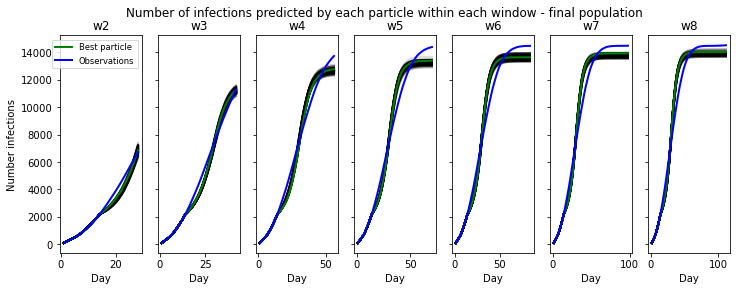

In [8]:
# Create figure
fig, axes = plt.subplots(1, len(window_lengths_dict)-1, figsize=(12,4), sharey = True)

# Create dictionary containing all items except the first item
# This is because the first window is length 14, and the model is seeded for 14 days
# thus the results are identical and the code fails 
windows_length_dict_w2_onwards = dict(list(window_lengths_dict.items())[1:])

# Loop through each window, adding a new subplot
for axes_number, (window, n_days)  in enumerate(windows_length_dict_w2_onwards.items()):
    # Define t (the last timeslice in the window)
    t = history.max_t
    # Get distances and predictions for this window
    daily_preds_l  = abc_sum_stats["{}_{}".format(window,t)]['daily_preds_l']   
    distance_l = abc_sum_stats["{}_{}".format(window,t)]['distance_l']   
    # Find the best particle
    best_particle_idx = abc_sum_stats["{}_{}".format(window,t)]['distance_l'].index(min(abc_sum_stats["{}_{}".format(window,t)]['distance_l']))

    # Normalise distance to 0-1 to calculate transparency
    _distance = np.array(distance_l)  # Easier to do maths on np.array
    distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))

    # Define x axis for plot (number of days these results relate to)
    x=range(1,n_days+1)    

    # For each particle, plot the predictions, coloured by distance
    for i in range(0,len(daily_preds_l)):
        axes[axes_number].plot(x, daily_preds_l[i], color="black", linewidth = 2, alpha=1-distance_norm[i])  # (1-x because high distance is bad)
    # Add the best particle
    axes[axes_number].plot(x, daily_preds_l[best_particle_idx], color="green", linewidth = 2,
                          label = 'Best particle')  # (1-x because high distance is bad)
    # Add observations
    axes[axes_number].plot(x, cases_devon_daily[0:len(daily_preds_l[0])], label="Observations",
                            linewidth = 2, color="blue")

    # Apply labels
    axes[axes_number].set_xlabel("Day")
    axes[axes_number].set_title("{}".format(window))

# Apply legend
axes[0].legend(fontsize="small")
axes[0].set_ylabel("Number infections")

# Set full plot title
fig.suptitle('Number of infections predicted by each particle within each window - final population'.format(t))

### Compare model predictions from each population in final calibration window to observations
The black lines are the predictions made by each particle in each population  
The green line is the best particle (the lowest distance between predictions and observations)  
The blue line is the observations

Text(0.5, 0.98, 'Number of infections predicted by each particle within each population in the final window ')

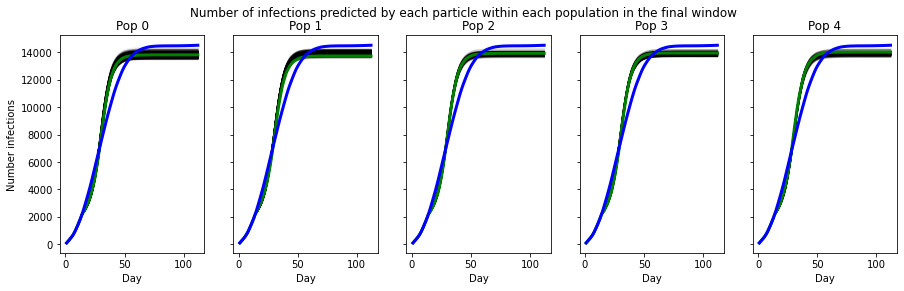

In [9]:
# Create figure
fig, axes = plt.subplots(1, history.max_t+1, figsize=(15,4), sharey=True)

# Loop through each population and plot its data on a subplot
for axes_number, t in enumerate(range(0, history.max_t+1)):
    # Create dictionary containing all items except the first item
    window, n_days = list(window_lengths_dict.items())[-1]
    
    # Find the best particle
    best_particle_idx = abc_sum_stats["{}_{}".format(window,t)]['distance_l'].index(min(abc_sum_stats["{}_{}".format(window,t)]['distance_l']))

    # Get data for this window
    daily_preds_l  = abc_sum_stats["{}_{}".format(window,t)]['daily_preds_l']   
    distance_l = abc_sum_stats["{}_{}".format(window,t)]['distance_l']   

    # Normalise distance to 0-1 to calculate transparency
    _distance = np.array(distance_l)  # Easier to do maths on np.array
    distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))

    # define number of days these results relate to
    x=range(1,n_days+1)    
    # For each particle, plot the predictions, coloured by distance
    for i in range(0,len(daily_preds_l)):
        axes[axes_number].plot(x, daily_preds_l[i], color="black", alpha=1-distance_norm[i])  # (1-x because high distance is bad)
    # Add the best particle
    axes[axes_number].plot(x, daily_preds_l[best_particle_idx], color="green", linewidth = 3,
                          label = 'Best particle')  # (1-x because high distance is bad)
    # Add observations
    axes[axes_number].plot(x, cases_devon_daily[0:len(daily_preds_l[0])], label="Observations",
                            linewidth = 3, color="blue")

    # Apply labels
    axes[axes_number].set_xlabel("Day")
    axes[axes_number].set_title("Pop {}".format(t))

axes[0].set_ylabel("Number infections")
# Apply legend
# axes[0].legend(fontsize="large")
    
# Set full plot title
fig.suptitle('Number of infections predicted by each particle within each population in the final window '.format(t))

## 3. Model predictions for the future using parameter values from dynamic calibration

#### a. Run the model for 105 days using the posterior parameter distributions from the dynamic calibration windows

##### Set up OpenCL runner

##### Use parameter distribution from final population of each window of dynamic calibration to run model for 105 days

In [73]:
## Define parameters
ITERATIONS = 77  # Number of days to run for
NUM_SEED_DAYS = 14  # Number of days to seed the population
USE_GPU = False
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")

# Define filepath to file containing default parameter values
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

# Optionally initialise the population, delete the old OpenCL model snapshot (i.e. an already-initialised model) and
# re-create a new one. Useful if something may have changed (e.g. changed the lockdown file).
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

# Initialise the class so that its ready to run the model.
OpenCLRunner.init(iterations = ITERATIONS,  repetitions = REPETITIONS,observations = cases_devon_weekly,
    use_healthier_pop = USE_HEALTHIER_POP, use_gpu = USE_GPU, store_detailed_counts = STORE_DETAILED_COUNTS,
    parameters_file = PARAMETERS_FILE,opencl_dir = OPENCL_DIR, snapshot_filepath = SNAPSHOT_FILEPATH,
     num_seed_days = NUM_SEED_DAYS, seed_days_start_day =  1) 

# Set constants 
current_risk_beta_val =0.019
const_params_dict = { "current_risk_beta": current_risk_beta_val,"home": 1.0}
OpenCLRunner.set_constants(const_params_dict)

#################################################
# Define the number of samples to take from the posterior distribution of parameters
N_samples = 30

# Create dictionary to store results for each window
windows_dict ={}

# Loop through each window
for window in window_lengths_dict.keys():

    # Define abc_history object from final window
    abc_history = history_dict[window]

    # Get dataframe of posterior parameter values
    df, w = abc_history.get_distribution(m=0, t=abc_history.max_t)

    # Sample from the dataframe of posteriors using KDE
    kde = MultivariateNormalTransition(scaling=1)
    kde.fit(df, w)
    samples = kde.rvs(N_samples)

    # Now run N models and store the results of each one
    distance_l, sim_l, obs_l, out_params_l,out_calibrated_params_l, summaries_l = [],[],[],[],[],[] 

    negative_count = 0  # Count the number of negatives returned in the KDE posterior
    for i, sample in samples.iterrows():
        # Check for negatives. If needed, resample
        while (sample < 0).values.any():
            #print("Found negatives. Resampling")
            negative_count += 1
            sample = kde.rvs()
            # Added in this line as the sample was in the wrong format for the while loop
            sample = pd.Series(sample)

        # Create a dictionary with the parameters and their values for this sample
        param_values = sample.to_dict()
        #print(param_values)
        
        # Update the day that the seeding starts from so that 
        day_to_start_seeding = int(window.replace('w', '')) * 14 + 1 - 14
        print("Window {}, start seeding on day {}".format(window, day_to_start_seeding))
        OpenCLRunner.update(seed_days_start_day=day_to_start_seeding)
        (_distance, _sim, _obs, _out_params, _summaries) = OpenCLRunner.run_model_with_params_abc(param_values, 
                        return_full_details=True)

        distance_l.append(_distance)
        sim_l.append(_sim)
        obs_l.append(_obs)
        out_params_l.append(_out_params)
        out_calibrated_params_l.append(param_values)
        summaries_l.append(_summaries)
    print(f"Finished sampling. Ignored {negative_count} negative samples.")

    # add to dictionary
    windows_dict[window] = {'distance': distance_l, 'sim': sim_l, 'obs':obs_l, 'summaries': summaries_l, 
                            'out_calibrated_params': out_calibrated_params_l, 'out_params': out_params_l}

Window w1, start seeding on day 1
Model daily infections:  [  101.    201.    301.    402.    508.    627.    766.    929.   1112.
  1307.   1510.   1720.   1941.   2180.   2375.2  2572.2  2809.8  3150.6
  3599.6  4201.8  5009.2  6053.6  7390.8  9003.  10755.  12621.  14496.8
 16284.  17964.  19572.8 21073.8 22470.  23660.4 24718.2 25642.  26466.4
 27195.4 27773.6 28265.6 28674.6 29024.4 29290.  29520.2 29716.  29868.
 29994.6 30110.2 30197.8 30275.  30343.8 30395.4 30438.2 30475.6 30508.2
 30542.8 30564.2 30583.8 30598.8 30612.6 30625.4 30638.2 30645.8 30656.4
 30665.  30674.4 30679.4 30686.  30691.6 30695.  30699.8 30704.2 30709.2
 30712.6 30715.8 30718.8 30721.6 30724.6]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e

Model daily infections:  [  101.    201.    301.    402.    508.    627.    766.    929.   1112.
  1307.   1510.   1720.   1941.   2180.   2365.2  2552.6  2778.8  3082.4
  3483.6  4022.4  4718.8  5653.2  6792.   8154.8  9681.8 11213.8 12748.
 14210.8 15576.4 16891.4 18117.6 19247.8 20271.6 21223.6 22064.6 22799.8
 23464.8 24039.6 24516.2 24914.2 25240.6 25510.4 25733.  25923.  26078.2
 26206.  26319.  26412.8 26489.  26557.  26611.  26656.6 26696.4 26730.6
 26758.4 26781.  26797.6 26814.8 26826.4 26838.4 26848.2 26858.  26867.2
 26874.6 26881.6 26889.2 26895.2 26899.6 26903.8 26908.2 26912.  26915.
 26920.2 26923.8 26927.4 26930.8 26933.4]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1

Model daily infections:  [  101.    201.    301.    402.    508.    627.    766.    929.   1112.
  1307.   1510.   1720.   1941.   2180.   2248.6  2318.6  2408.   2513.
  2642.2  2788.8  2972.8  3190.2  3442.2  3760.2  4114.8  4518.6  4988.
  5496.2  6002.2  6534.4  7082.4  7600.6  8050.8  8435.4  8783.2  9067.
  9322.6  9507.8  9661.2  9778.4  9871.4  9942.   9993.6 10041.4 10071.6
 10094.8 10113.  10129.4 10141.  10148.6 10154.6 10160.6 10165.  10166.8
 10168.6 10170.  10170.6 10171.8 10172.2 10173.  10173.8 10174.2 10174.4
 10174.4 10174.6 10174.6 10174.6 10174.8 10175.  10175.  10175.  10175.
 10175.  10175.  10175.  10175.  10175. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.0

Model daily infections:  [  101.    201.    301.    402.    508.    627.    766.    929.   1112.
  1307.   1510.   1720.   1941.   2180.   2354.4  2542.2  2742.4  2998.
  3320.8  3719.8  4227.2  4853.8  5662.2  6630.2  7752.2  9041.2 10438.4
 11880.6 13310.8 14722.2 16055.8 17276.6 18329.4 19242.8 20017.4 20683.2
 21266.2 21751.6 22140.  22463.6 22724.  22921.4 23079.  23215.8 23317.2
 23402.2 23472.8 23530.6 23581.  23622.2 23650.4 23671.2 23690.8 23704.
 23715.  23724.8 23733.  23739.  23745.4 23749.8 23753.6 23757.6 23760.6
 23764.  23767.6 23769.2 23770.2 23771.2 23773.  23773.8 23774.4 23775.2
 23775.4 23776.6 23777.4 23777.8 23778. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1

Model daily infections:  [  101.    201.    301.    402.    508.    627.    766.    929.   1112.
  1307.   1510.   1720.   1941.   2180.   2304.6  2450.2  2599.8  2782.
  3005.2  3264.8  3592.   3991.6  4455.6  5006.6  5663.4  6391.   7173.2
  7990.4  8798.2  9616.2 10366.6 11023.4 11585.2 12070.  12466.8 12819.4
 13126.2 13366.2 13566.8 13721.8 13850.4 13950.8 14028.8 14100.6 14153.4
 14193.6 14224.6 14253.8 14275.8 14295.4 14308.4 14321.  14331.4 14341.
 14346.2 14351.8 14355.6 14359.6 14362.8 14364.4 14366.8 14369.  14369.8
 14371.  14372.2 14373.8 14374.6 14375.  14375.6 14375.6 14375.8 14376.
 14376.4 14377.4 14377.4 14377.4 14377.6]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.

Model daily infections:  [  101.    201.    301.    402.    508.    627.    766.    929.   1112.
  1307.   1510.   1720.   1941.   2180.   2330.6  2483.2  2666.8  2885.8
  3143.2  3443.   3820.6  4277.   4812.   5474.6  6247.8  7115.2  8045.8
  9023.  10001.4 10953.  11827.  12634.2 13300.6 13882.6 14377.6 14797.2
 15167.2 15461.2 15699.6 15897.6 16061.6 16194.8 16296.4 16375.  16441.6
 16493.6 16539.  16578.8 16610.6 16637.4 16656.8 16672.  16681.2 16689.
 16696.4 16703.6 16709.6 16713.8 16717.6 16720.2 16723.4 16724.4 16725.8
 16727.6 16728.4 16729.  16730.  16730.8 16731.8 16732.4 16732.8 16733.2
 16734.2 16734.2 16734.2 16735.2 16735.4]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 

Model daily infections:  [  261.    540.    830.   1127.   1429.   1738.   2059.   2394.   2741.
  3095.   3453.   3811.   4168.   4523.   4754.2  5002.2  5258.8  5561.8
  5906.2  6292.6  6721.2  7222.4  7792.   8459.2  9191.8  9988.  10831.2
 11704.4 12612.2 13538.  14429.8 15241.4 15952.4 16589.6 17128.4 17574.4
 17981.6 18298.2 18576.4 18794.8 18959.6 19091.4 19192.  19272.6 19336.4
 19387.2 19430.8 19462.  19485.4 19504.8 19521.8 19533.4 19540.  19547.2
 19553.6 19558.6 19561.2 19564.6 19567.  19568.4 19570.  19570.6 19571.4
 19572.2 19573.  19573.6 19573.8 19573.8 19574.  19574.2 19574.4 19574.4
 19574.4 19574.6 19574.6 19574.6 19574.8]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02

Model daily infections:  [  261.    540.    830.   1127.   1429.   1738.   2059.   2394.   2741.
  3095.   3453.   3811.   4168.   4523.   4769.4  5030.4  5305.2  5592.6
  5927.   6301.2  6721.   7186.8  7709.6  8297.6  8974.6  9679.8 10438.
 11215.4 12003.8 12799.6 13568.  14287.8 14935.  15487.8 15948.  16352.4
 16686.  16947.8 17175.  17336.2 17461.2 17553.6 17623.6 17676.2 17718.2
 17750.  17776.  17796.4 17809.2 17820.8 17827.  17834.2 17838.2 17843.2
 17847.2 17850.2 17852.2 17853.2 17853.8 17854.6 17855.6 17856.2 17856.6
 17856.8 17856.8 17857.  17857.2 17857.4 17857.4 17857.4 17857.4 17857.8
 17857.8 17858.  17858.  17858.  17858. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 

Model daily infections:  [  261.    540.    830.   1127.   1429.   1738.   2059.   2394.   2741.
  3095.   3453.   3811.   4168.   4523.   4752.2  4983.   5206.   5488.4
  5819.4  6181.6  6609.2  7106.   7705.2  8347.   9078.6  9830.4 10645.6
 11446.  12252.6 13054.2 13818.4 14497.  15062.2 15526.8 15946.4 16303.8
 16606.6 16864.8 17059.6 17222.4 17350.6 17452.2 17532.2 17596.4 17650.8
 17687.8 17717.2 17746.8 17766.2 17780.8 17790.8 17802.  17808.  17813.6
 17817.4 17821.6 17824.6 17828.  17829.4 17830.2 17830.4 17831.2 17831.6
 17833.  17833.2 17833.4 17833.4 17833.4 17833.4 17833.8 17833.8 17833.8
 17833.8 17833.8 17833.8 17833.8 17833.8]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02

Model daily infections:  [  261.    540.    830.   1127.   1429.   1738.   2059.   2394.   2741.
  3095.   3453.   3811.   4168.   4523.   4777.8  5049.2  5313.2  5630.4
  5949.8  6323.2  6748.   7233.6  7791.6  8403.8  9077.   9773.4 10534.2
 11295.2 12065.4 12816.2 13517.4 14139.  14723.6 15201.2 15607.4 15951.2
 16260.2 16503.8 16707.4 16876.  17011.8 17122.8 17207.8 17275.6 17332.2
 17379.6 17419.2 17452.6 17473.4 17493.8 17509.4 17523.  17531.6 17540.8
 17546.4 17552.  17557.  17560.2 17563.  17563.8 17565.4 17566.6 17567.8
 17569.  17570.  17571.2 17571.8 17571.8 17572.2 17572.4 17572.8 17572.8
 17573.2 17573.2 17573.2 17573.2 17573.2]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02

Model daily infections:  [  261.    540.    830.   1127.   1429.   1738.   2059.   2394.   2741.
  3095.   3453.   3811.   4168.   4523.   4767.4  5025.   5273.6  5551.
  5849.6  6210.4  6595.8  7032.6  7534.   8070.6  8669.4  9330.2  9993.4
 10695.6 11433.2 12180.4 12903.6 13564.4 14145.6 14673.4 15106.8 15484.
 15810.2 16060.2 16270.6 16443.2 16565.6 16657.8 16730.4 16789.2 16833.
 16867.2 16893.4 16918.2 16936.8 16947.2 16959.8 16966.8 16973.2 16978.4
 16980.8 16983.  16984.6 16986.4 16987.8 16990.2 16991.  16991.8 16993.2
 16994.  16994.4 16994.8 16995.2 16995.2 16995.6 16995.8 16996.  16996.
 16996.4 16996.8 16996.8 16996.8 16996.8]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.0

Model daily infections:  [  261.    540.    830.   1127.   1429.   1738.   2059.   2394.   2741.
  3095.   3453.   3811.   4168.   4523.   4783.2  5047.8  5310.8  5611.6
  5939.2  6327.   6751.4  7260.4  7806.8  8426.8  9104.   9816.8 10572.2
 11333.  12110.2 12892.  13620.4 14274.  14836.4 15318.8 15711.  16060.6
 16353.  16579.4 16744.6 16887.  16992.6 17076.2 17138.2 17193.8 17235.
 17259.4 17282.2 17301.2 17318.2 17329.8 17339.6 17345.2 17349.4 17353.2
 17356.  17358.2 17360.4 17361.4 17361.8 17362.6 17363.6 17363.8 17364.
 17364.2 17364.4 17364.8 17365.  17365.  17365.  17365.  17365.  17365.
 17365.  17365.  17365.  17365.  17365. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.

Model daily infections:  [  353.    704.   1054.   1403.   1749.   2091.   2425.   2749.   3066.
  3378.   3686.   3988.   4279.   4553.   4801.2  5034.6  5264.6  5530.8
  5828.4  6157.8  6513.2  6930.4  7404.4  7923.6  8505.   9128.8  9786.4
 10469.8 11142.  11810.  12464.2 13044.2 13538.  13969.  14322.4 14640.
 14895.2 15107.  15273.8 15403.8 15500.4 15581.  15645.8 15694.  15729.6
 15761.8 15785.2 15800.6 15815.6 15825.8 15835.  15843.2 15847.  15849.8
 15852.2 15855.8 15857.6 15860.2 15861.  15862.2 15862.4 15862.6 15862.8
 15863.6 15863.6 15864.  15864.2 15864.2 15864.2 15864.2 15864.2 15864.2
 15864.2 15864.2 15864.4 15864.4 15864.4]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 

Model daily infections:  [  353.    704.   1054.   1403.   1749.   2091.   2425.   2749.   3066.
  3378.   3686.   3988.   4279.   4553.   4773.8  4984.8  5186.4  5422.4
  5680.8  5963.   6292.4  6651.4  7052.6  7502.6  8027.6  8572.2  9166.2
  9778.6 10419.8 11081.4 11751.8 12370.6 12956.4 13460.4 13904.4 14292.8
 14631.  14903.6 15130.6 15308.2 15462.  15577.  15675.6 15747.4 15807.6
 15853.6 15899.  15926.6 15947.8 15967.8 15986.  15997.8 16006.4 16015.2
 16023.  16027.8 16031.4 16034.2 16038.2 16040.  16042.2 16043.2 16045.4
 16045.8 16047.  16047.4 16047.6 16048.  16048.2 16048.6 16048.6 16048.8
 16048.8 16048.8 16049.  16049.  16049. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02

Model daily infections:  [  353.    704.   1054.   1403.   1749.   2091.   2425.   2749.   3066.
  3378.   3686.   3988.   4279.   4553.   4824.6  5083.8  5353.   5620.8
  5923.6  6253.8  6616.6  7034.8  7477.4  7977.8  8519.   9132.4  9744.4
 10389.4 11056.8 11731.4 12424.  13054.2 13619.6 14113.2 14536.4 14920.2
 15262.  15543.4 15757.8 15926.2 16068.8 16182.2 16268.2 16343.  16394.6
 16439.6 16470.  16498.4 16517.  16536.8 16549.8 16558.8 16566.8 16572.8
 16578.4 16582.4 16586.2 16589.4 16592.6 16594.  16595.4 16596.6 16597.2
 16597.8 16598.4 16599.  16599.  16599.2 16599.4 16599.4 16599.6 16599.6
 16599.6 16599.6 16599.8 16599.8 16599.8]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02

Model daily infections:  [  353.    704.   1054.   1403.   1749.   2091.   2425.   2749.   3066.
  3378.   3686.   3988.   4279.   4553.   4812.8  5068.4  5325.6  5601.2
  5912.6  6259.8  6652.   7082.   7581.   8121.2  8723.6  9380.6 10079.6
 10791.  11492.  12224.2 12951.4 13569.2 14117.6 14607.  15003.6 15349.2
 15646.2 15879.  16073.2 16224.2 16328.6 16408.8 16478.6 16528.6 16565.6
 16602.4 16627.8 16651.  16666.8 16678.  16686.8 16692.8 16699.8 16703.8
 16707.  16708.2 16711.4 16713.4 16715.2 16716.6 16717.2 16718.4 16719.2
 16719.8 16720.2 16720.6 16721.  16721.  16721.  16721.2 16721.2 16721.6
 16721.6 16721.8 16721.8 16721.8 16722. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02

Model daily infections:  [  353.    704.   1054.   1403.   1749.   2091.   2425.   2749.   3066.
  3378.   3686.   3988.   4279.   4553.   4805.4  5051.   5294.2  5574.8
  5871.4  6192.2  6555.   6942.4  7421.8  7940.   8495.6  9093.6  9729.2
 10388.6 11063.4 11753.8 12425.  13060.2 13614.2 14092.2 14522.4 14878.
 15192.  15442.  15650.2 15813.  15940.2 16044.  16123.  16177.  16223.6
 16260.  16291.4 16314.2 16331.  16344.2 16355.4 16366.6 16371.  16376.6
 16380.2 16382.2 16383.8 16385.4 16386.8 16387.8 16388.  16388.4 16389.2
 16389.6 16390.  16390.2 16390.4 16390.6 16390.6 16390.6 16390.6 16390.6
 16390.6 16390.6 16390.6 16390.6 16390.6]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 

Model daily infections:  [  353.    704.   1054.   1403.   1749.   2091.   2425.   2749.   3066.
  3378.   3686.   3988.   4279.   4553.   4785.6  5020.   5248.2  5486.6
  5751.6  6055.4  6402.8  6794.   7224.4  7714.8  8251.4  8832.2  9449.2
 10080.6 10718.6 11348.8 11997.  12578.4 13094.4 13533.8 13901.4 14231.8
 14534.  14763.2 14944.2 15088.  15201.4 15294.2 15367.6 15425.2 15466.4
 15501.8 15533.8 15554.8 15571.4 15584.4 15594.8 15602.2 15607.8 15612.6
 15618.  15621.  15623.8 15626.2 15627.2 15628.8 15630.4 15631.4 15631.8
 15632.8 15632.8 15633.4 15633.6 15633.8 15633.8 15634.  15634.  15634.
 15634.2 15634.2 15634.2 15634.2 15634.2]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 

Model daily infections:  [  253.    489.    715.    934.   1146.   1347.   1531.   1693.   1838.
  1972.   2099.   2221.   2335.   2437.   2550.   2661.2  2772.   2890.
  3035.6  3185.   3355.2  3553.4  3779.   4055.2  4374.8  4703.4  5097.6
  5504.4  5967.8  6458.6  6984.8  7488.8  7963.4  8387.   8791.4  9157.2
  9485.2  9764.4 10000.8 10195.  10356.4 10488.4 10593.  10675.2 10742.
 10794.6 10844.6 10887.4 10915.  10938.4 10961.4 10980.4 10993.2 11004.6
 11012.2 11019.8 11026.4 11030.  11035.2 11037.  11040.  11041.  11042.
 11043.2 11044.6 11045.  11045.4 11046.  11046.6 11046.6 11047.  11047.
 11047.4 11047.4 11047.4 11047.8 11048.2]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.0

Model daily infections:  [  253.    489.    715.    934.   1146.   1347.   1531.   1693.   1838.
  1972.   2099.   2221.   2335.   2437.   2555.2  2657.8  2755.2  2867.6
  2993.8  3144.   3295.2  3478.   3698.   3932.8  4192.   4514.   4843.8
  5199.8  5598.4  6018.   6465.   6899.4  7301.8  7693.   8036.   8362.4
  8644.2  8890.6  9086.6  9256.8  9397.6  9517.   9611.   9684.4  9744.
  9794.8  9838.4  9872.6  9896.   9922.6  9936.8  9952.2  9962.6  9968.8
  9975.   9980.6  9985.8  9990.   9993.   9996.   9997.4  9999.  10000.
 10001.8 10003.  10003.8 10004.6 10006.2 10006.4 10007.2 10007.8 10007.8
 10007.8 10008.2 10008.4 10008.8 10008.8]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1

Model daily infections:  [  253.    489.    715.    934.   1146.   1347.   1531.   1693.   1838.
  1972.   2099.   2221.   2335.   2437.   2551.4  2652.2  2749.4  2862.2
  2996.8  3147.   3317.8  3513.8  3755.2  4052.8  4380.2  4750.   5181.2
  5639.8  6136.6  6678.2  7211.6  7742.   8231.6  8689.2  9106.8  9504.8
  9842.  10127.6 10384.2 10578.6 10751.4 10890.4 11008.2 11100.4 11179.8
 11242.2 11291.2 11331.8 11363.  11389.4 11410.  11425.  11438.  11447.2
 11456.2 11463.4 11470.4 11473.8 11477.4 11480.2 11482.6 11485.6 11487.
 11487.8 11488.6 11490.4 11491.  11491.6 11491.8 11492.  11492.  11492.6
 11492.8 11492.8 11492.8 11492.8 11492.8]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 

Model daily infections:  [  253.    489.    715.    934.   1146.   1347.   1531.   1693.   1838.
  1972.   2099.   2221.   2335.   2437.   2559.   2671.   2781.4  2897.8
  3040.   3196.8  3370.2  3580.   3834.6  4114.4  4451.4  4830.2  5254.
  5718.   6188.   6722.2  7253.8  7759.6  8232.   8661.   9024.6  9373.
  9659.8  9901.6 10101.6 10262.6 10394.  10490.  10565.8 10635.4 10688.6
 10734.2 10767.8 10795.8 10816.6 10832.6 10847.  10859.  10867.6 10873.6
 10878.8 10881.6 10883.8 10885.8 10887.8 10889.6 10891.4 10891.8 10892.6
 10893.4 10893.4 10893.8 10894.  10894.2 10894.2 10894.4 10894.4 10894.4
 10894.4 10894.4 10894.4 10894.4 10894.4]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1

Model daily infections:  [  253.    489.    715.    934.   1146.   1347.   1531.   1693.   1838.
  1972.   2099.   2221.   2335.   2437.   2559.2  2673.   2790.2  2907.
  3054.   3221.4  3402.4  3617.2  3846.2  4137.4  4459.6  4800.4  5187.2
  5624.4  6073.2  6543.   7036.2  7536.8  8019.8  8462.   8859.6  9226.2
  9543.8  9815.  10053.  10240.2 10394.4 10518.4 10621.8 10704.8 10775.6
 10842.6 10896.8 10936.8 10968.6 10991.4 11013.8 11031.  11041.  11051.6
 11060.4 11067.6 11072.8 11075.8 11079.4 11082.  11083.8 11085.6 11087.6
 11088.8 11089.4 11090.8 11091.2 11092.  11092.4 11093.  11093.8 11094.
 11094.4 11094.8 11094.8 11094.8 11095. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1

Model daily infections:  [  253.    489.    715.    934.   1146.   1347.   1531.   1693.   1838.
  1972.   2099.   2221.   2335.   2437.   2560.4  2674.6  2798.   2926.2
  3061.2  3208.8  3389.8  3593.8  3834.   4081.   4389.2  4711.2  5064.4
  5454.   5875.   6318.2  6778.4  7218.   7633.6  8020.2  8364.6  8671.
  8952.4  9171.8  9365.6  9531.6  9663.   9763.4  9843.   9914.8  9967.6
 10009.8 10043.8 10071.2 10094.4 10110.6 10126.2 10139.4 10149.4 10154.8
 10160.  10165.  10168.6 10172.2 10173.6 10175.  10176.4 10177.6 10178.6
 10178.8 10179.  10179.8 10180.8 10180.8 10181.2 10181.6 10181.6 10181.6
 10181.8 10182.  10182.2 10182.4 10182.4]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 

Model daily infections:  [  86.   159.   225.   286.   345.   400.   448.   488.   522.   552.
  579.   605.   628.   648.   672.   692.4  712.8  733.6  758.   785.6
  816.4  853.4  893.8  950.8 1015.4 1088.2 1170.8 1267.4 1368.6 1483.8
 1616.8 1760.2 1903.6 2039.4 2177.6 2301.4 2424.8 2536.4 2639.4 2733.
 2816.2 2879.4 2929.2 2983.6 3024.4 3061.2 3094.4 3122.4 3146.2 3166.6
 3189.6 3206.6 3219.2 3228.8 3236.8 3244.8 3253.8 3259.2 3263.8 3269.2
 3273.2 3277.8 3282.  3284.8 3288.  3289.6 3291.8 3293.2 3294.6 3295.8
 3296.8 3297.8 3298.6 3299.4 3300.  3301.  3301.6]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6

Model daily infections:  [  86.   159.   225.   286.   345.   400.   448.   488.   522.   552.
  579.   605.   628.   648.   675.8  697.   722.   749.   780.6  812.6
  850.6  899.8  958.6 1033.2 1111.4 1206.6 1317.4 1442.  1594.  1754.6
 1935.2 2132.6 2319.8 2495.  2669.  2838.2 3005.2 3151.8 3278.2 3382.2
 3481.  3557.4 3630.6 3696.  3744.  3787.2 3822.8 3857.2 3885.6 3909.2
 3930.2 3946.2 3959.2 3971.8 3984.2 3990.6 4000.  4008.4 4013.4 4019.
 4023.2 4025.4 4028.6 4031.  4033.2 4035.2 4037.  4037.4 4038.  4039.2
 4040.  4040.8 4041.8 4042.6 4043.  4043.  4043. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6

Model daily infections:  [  86.   159.   225.   286.   345.   400.   448.   488.   522.   552.
  579.   605.   628.   648.   677.   704.4  729.4  755.2  791.2  823.8
  861.4  908.8  964.6 1028.6 1102.  1195.8 1298.  1403.8 1528.4 1664.
 1816.  1971.8 2134.8 2288.8 2440.4 2583.6 2715.6 2834.  2932.8 3022.6
 3105.  3165.8 3216.6 3269.2 3309.8 3342.8 3366.2 3393.  3411.8 3430.2
 3445.2 3456.4 3468.  3478.4 3486.8 3494.2 3499.  3503.  3509.8 3513.2
 3515.2 3517.  3518.6 3520.  3521.4 3522.2 3522.8 3523.4 3524.  3524.6
 3525.  3525.6 3526.2 3526.4 3527.2 3527.4 3527.6]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6

Model daily infections:  [  86.   159.   225.   286.   345.   400.   448.   488.   522.   552.
  579.   605.   628.   648.   679.2  704.2  726.8  756.2  790.4  827.6
  872.8  927.8  995.  1076.4 1167.4 1279.4 1407.6 1541.6 1699.2 1878.4
 2090.6 2281.6 2502.8 2708.4 2916.8 3115.  3306.  3470.8 3626.2 3749.2
 3856.6 3938.  4019.2 4089.2 4150.8 4199.  4241.6 4273.6 4304.2 4330.2
 4351.8 4369.2 4386.8 4399.4 4411.4 4421.4 4428.8 4435.4 4440.6 4445.4
 4448.8 4452.8 4456.  4459.2 4461.  4463.2 4465.6 4467.  4467.6 4468.4
 4469.4 4470.  4470.2 4471.  4471.8 4472.6 4473. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 

Model daily infections:  [  86.   159.   225.   286.   345.   400.   448.   488.   522.   552.
  579.   605.   628.   648.   677.   702.8  727.6  750.8  778.8  813.4
  854.   901.   952.8 1016.  1088.8 1175.8 1274.  1382.4 1497.8 1640.8
 1794.  1946.4 2099.6 2254.  2406.8 2546.  2677.4 2800.8 2907.6 2999.4
 3083.  3148.2 3209.  3258.  3305.4 3343.8 3379.6 3409.8 3430.8 3451.
 3467.6 3482.  3494.4 3503.2 3510.  3516.6 3522.2 3526.8 3531.4 3534.6
 3537.4 3539.6 3541.6 3542.6 3543.8 3546.  3546.8 3548.2 3548.6 3549.4
 3550.  3550.6 3551.  3551.4 3551.4 3551.8 3552. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6

Model daily infections:  [  86.   159.   225.   286.   345.   400.   448.   488.   522.   552.
  579.   605.   628.   648.   682.   710.6  734.8  765.4  797.8  834.
  874.6  929.   986.2 1052.4 1129.2 1225.2 1317.2 1432.6 1566.  1702.2
 1848.  2009.6 2168.  2325.8 2475.8 2625.2 2768.4 2895.  3002.  3105.
 3189.2 3264.2 3321.  3379.6 3419.6 3454.2 3488.6 3519.  3538.8 3564.8
 3582.6 3595.  3607.2 3617.2 3626.4 3637.2 3643.4 3647.2 3653.4 3656.4
 3659.8 3662.  3664.8 3667.6 3668.4 3668.8 3670.2 3671.  3671.6 3672.2
 3673.2 3673.4 3674.6 3675.6 3675.6 3676.  3676. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.

Model daily infections:  [ 15.   26.   35.   43.   50.   57.   62.   66.   69.   71.   73.   74.
  75.   76.   79.8  82.   85.8  88.6  92.4  96.  102.2 109.  116.6 127.2
 137.4 150.6 167.6 186.8 209.4 235.  258.  290.2 322.2 353.4 383.2 413.4
 447.2 475.2 504.8 531.  554.  573.8 593.6 608.4 624.  636.6 648.  657.4
 666.8 673.8 681.  686.6 692.6 697.  701.2 704.  707.8 709.8 712.2 713.4
 715.6 718.2 720.2 721.8 722.2 722.8 723.4 724.4 725.4 725.8 726.4 727.2
 727.6 727.6 727.8 728.4 728.4]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.

Model daily infections:  [ 15.   26.   35.   43.   50.   57.   62.   66.   69.   71.   73.   74.
  75.   76.   79.8  82.2  85.4  87.8  90.6  94.8  99.2 103.8 110.4 119.
 127.  139.2 151.  164.  177.6 197.  219.6 237.  259.  281.  298.6 317.
 339.4 359.2 376.6 390.8 405.2 416.2 427.6 439.4 448.4 454.8 459.8 467.6
 472.8 476.  478.8 481.8 484.  485.8 487.6 489.2 489.8 492.2 492.6 493.8
 494.4 495.4 496.  496.2 496.4 496.8 497.  497.4 498.  498.2 498.6 499.
 499.  499.4 500.2 500.2 500.4]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.501

Model daily infections:  [ 15.   26.   35.   43.   50.   57.   62.   66.   69.   71.   73.   74.
  75.   76.   79.   81.2  83.4  88.   91.2  95.   98.8 102.6 108.8 117.2
 127.6 135.6 144.4 159.6 176.6 193.  212.2 230.2 253.2 275.6 298.8 314.4
 336.4 354.8 372.4 388.2 400.  409.  418.8 430.8 439.2 443.8 450.  454.2
 458.2 461.  465.2 467.6 469.6 473.4 474.  475.  476.8 477.8 479.4 480.6
 481.2 482.  482.6 483.4 484.2 484.8 485.6 485.6 486.  486.6 487.  487.
 487.  487.  488.  488.  488.2]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.5

Model daily infections:  [ 15.   26.   35.   43.   50.   57.   62.   66.   69.   71.   73.   74.
  75.   76.   78.8  80.6  83.   86.6  89.   91.4  93.6  98.4 101.2 104.6
 109.6 116.  121.8 129.  136.4 146.4 158.  166.8 178.2 191.4 201.6 210.8
 220.6 230.2 238.6 246.4 254.8 260.8 265.  269.8 273.4 275.4 280.4 282.4
 285.  286.  288.  289.2 290.  290.6 291.4 292.2 292.8 293.2 293.2 293.2
 293.4 293.6 293.6 293.8 294.  294.4 294.4 294.8 295.  295.  295.  295.2
 295.4 295.6 295.6 295.8 295.8]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.

Model daily infections:  [ 15.   26.   35.   43.   50.   57.   62.   66.   69.   71.   73.   74.
  75.   76.   79.6  81.2  83.8  86.2  90.2  93.4  97.4 102.2 109.  115.8
 124.6 135.6 148.8 161.  176.2 194.4 214.2 234.  257.2 281.  303.4 322.2
 343.8 366.8 386.4 400.4 416.4 428.4 438.2 446.4 455.8 463.  470.8 476.8
 481.2 487.4 490.8 493.  496.6 499.6 503.2 505.  506.8 508.  509.4 510.
 510.8 512.  512.8 513.6 513.8 514.8 515.2 515.4 515.4 515.8 515.8 515.8
 515.8 515.8 516.2 516.2 516.2]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.5

Model daily infections:  [ 15.   26.   35.   43.   50.   57.   62.   66.   69.   71.   73.   74.
  75.   76.   78.6  80.   82.   84.4  85.6  88.2  90.8  94.4  97.2 100.4
 106.2 109.4 117.2 123.  129.  138.8 150.2 158.2 169.2 179.  187.8 196.6
 207.  216.4 224.  229.6 235.6 241.  244.4 249.4 252.6 255.6 258.2 259.2
 261.8 262.6 263.8 265.2 266.2 266.8 267.2 267.4 269.  270.  270.6 270.8
 271.  271.2 271.6 272.  272.  272.2 272.8 272.8 272.8 273.  273.6 273.6
 273.8 273.8 274.2 274.2 274.4]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.

Model daily infections:  [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   2.
  2.   2.4  2.6  2.8  3.   3.6  4.   4.4  5.   5.6  5.8  6.4  7.2  8.8
 10.2 11.6 12.4 14.4 15.6 16.4 19.4 20.8 22.6 23.6 25.8 27.4 28.  28.8
 30.  30.8 31.4 32.  32.4 32.8 33.6 34.8 34.8 34.8 35.  35.2 35.4 35.6
 35.8 35.8 36.  36.  36.  36.  36.  36.  36.  36.  36.2 36.2 36.4 36.4
 36.6 36.6 36.6 36.6 36.6 36.6 36.6]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.50142182e+03 8.59889171e+03 7.36000974e+03
 7.06343053e+03 8.37359178e+03 1.09

Model daily infections:  [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  2.  2.  2.2 2.2
 2.2 2.4 3.  3.  3.2 3.4 3.8 3.8 4.  4.  4.4 4.8 5.  5.2 5.6 5.6 5.8 6.2
 6.6 6.6 6.8 6.8 7.  7.  7.2 7.2 7.4 7.4 7.4 7.4 7.4 7.4 7.4 7.6 7.6 7.6
 7.6 7.6 7.6 7.6 7.6 7.6 7.6 7.6 7.6 7.6 7.6 7.6 7.6 7.6 7.6 7.6 7.6 7.6
 7.6 7.6 7.6 7.6 7.6]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.50142182e+03 8.59889171e+03 7.36000974e+03
 7.06343053e+03 8.37359178e+03 1.09732577e+04 1.39581315e+04
 1.68199754e+04 1.79324925e+04 1.58295324e+04 1.170

Model daily infections:  [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  2.  2.  2.  2.2
 2.4 2.4 2.6 2.6 2.6 2.6 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8
 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8
 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8 2.8
 2.8 2.8 2.8 2.8 2.8]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.50142182e+03 8.59889171e+03 7.36000974e+03
 7.06343053e+03 8.37359178e+03 1.09732577e+04 1.39581315e+04
 1.68199754e+04 1.79324925e+04 1.58295324e+04 1.170

Model daily infections:  [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   2.
  2.   2.   2.   2.2  2.4  2.4  3.   3.2  3.6  3.8  4.8  5.2  6.   6.2
  7.2  8.6  9.6 10.2 11.4 12.  13.  13.6 15.  15.6 16.2 16.8 17.  17.4
 17.6 18.2 18.2 18.4 18.6 18.6 19.  19.6 19.6 20.  20.  20.  20.  20.
 20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.
 20.  20.  20.  20.  20.  20.  20. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.50142182e+03 8.59889171e+03 7.36000974e+03
 7.06343053e+03 8.37359178e+03 1.0973

Model daily infections:  [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   2.
  2.   2.4  2.4  2.8  3.   3.   3.2  4.6  4.8  5.4  5.6  6.4  7.2  8.2
  9.  10.6 12.8 14.4 15.  18.  19.8 22.2 22.4 23.4 24.6 25.4 27.4 28.
 28.6 29.4 29.4 30.2 30.4 30.6 31.2 31.2 31.2 31.2 31.4 32.  32.  32.
 32.  32.2 32.8 32.8 32.8 32.8 33.  33.  33.  33.  33.  33.  33.  33.
 33.  33.  33.  33.  33.  33.  33. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.50142182e+03 8.59889171e+03 7.36000974e+03
 7.06343053e+03 8.37359178e+03 1.09732

Model daily infections:  [  1.    2.    3.    4.    5.    7.    9.   11.   13.   16.   19.   22.
  25.   28.   30.2  32.   35.8  37.6  41.6  45.6  51.2  58.2  65.4  76.2
  90.8 105.  122.  144.2 170.4 200.4 232.  265.8 302.2 339.4 370.  409.4
 437.  470.8 499.8 524.2 549.  569.8 590.6 606.6 621.4 637.  648.6 657.2
 664.4 671.2 680.6 688.  691.6 696.6 699.4 702.8 706.4 708.8 711.2 712.8
 715.  715.8 716.6 717.2 718.  719.  720.  720.6 721.8 721.8 722.4 723.
 723.  723.4 723.8 724.  724.2]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.5

Model daily infections:  [  1.    2.    3.    4.    5.    7.    9.   11.   13.   16.   19.   22.
  25.   28.   30.6  33.2  35.6  38.8  43.6  46.   51.   57.   61.8  68.
  72.8  80.4  86.6  93.4 103.2 113.6 124.4 137.  150.4 161.6 174.8 183.6
 196.4 204.6 216.2 224.6 231.2 236.8 241.  244.8 248.4 252.  254.2 256.8
 258.4 261.6 263.  264.8 265.6 266.4 267.4 267.8 268.8 269.2 269.6 269.8
 270.  270.4 271.2 271.2 271.2 271.4 271.6 271.6 271.6 271.8 271.8 271.8
 271.8 272.  272.  272.  272. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.5

Model daily infections:  [  1.    2.    3.    4.    5.    7.    9.   11.   13.   16.   19.   22.
  25.   28.   29.8  31.6  33.2  34.6  37.   39.8  43.6  46.8  50.   56.8
  62.4  67.8  75.6  85.   96.  107.  121.4 134.6 150.8 167.2 185.4 201.4
 219.6 235.2 246.2 258.8 270.4 280.6 288.8 295.6 300.6 309.2 315.4 320.
 323.  327.2 328.8 330.8 332.8 335.4 337.  338.2 339.8 341.  341.  341.6
 341.8 341.8 342.  342.8 343.2 343.6 344.  344.  344.  344.  344.2 344.2
 344.2 344.4 344.4 344.6 344.6]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.5

Model daily infections:  [  1.    2.    3.    4.    5.    7.    9.   11.   13.   16.   19.   22.
  25.   28.   30.4  34.8  38.   41.4  45.   50.   53.4  60.8  67.   74.
  84.8  99.8 114.4 130.6 148.4 168.  191.  212.8 237.6 258.4 279.2 306.4
 332.4 347.8 367.2 383.  394.4 407.2 416.4 425.2 432.2 440.8 447.  453.8
 458.  461.6 465.6 468.  471.6 473.4 475.8 477.6 478.6 480.  482.2 482.8
 484.2 484.4 485.2 485.4 486.  487.2 487.6 488.2 488.6 488.8 489.  489.2
 489.2 489.2 489.4 489.8 490. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.5

Model daily infections:  [  1.    2.    3.    4.    5.    7.    9.   11.   13.   16.   19.   22.
  25.   28.   28.8  31.   33.   36.   38.4  43.   47.   53.8  59.6  66.2
  74.2  84.6  96.  108.8 125.6 144.6 166.  188.2 213.2 238.2 260.4 285.4
 313.6 332.  350.4 367.6 381.2 394.6 410.8 423.2 435.  443.2 451.4 460.6
 466.  472.2 478.  482.  486.4 490.2 494.2 496.8 499.2 501.2 502.  505.4
 507.  508.  509.8 510.6 511.2 512.4 512.8 514.2 514.4 515.6 516.8 517.4
 517.8 518.8 519.2 519.8 520.6]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.

Model daily infections:  [  1.    2.    3.    4.    5.    7.    9.   11.   13.   16.   19.   22.
  25.   28.   30.4  32.   35.   37.6  40.4  44.4  48.   52.   58.   62.8
  72.6  81.   94.2 107.  119.6 135.4 153.2 171.2 194.4 213.6 231.8 251.6
 273.8 291.8 306.6 320.  333.  343.2 353.4 364.  370.2 376.6 382.6 388.
 393.2 397.8 400.8 405.6 408.6 411.4 413.6 415.  416.2 417.2 419.4 420.6
 420.8 421.6 422.6 422.8 423.2 423.6 424.  424.2 424.4 424.4 424.6 424.6
 424.8 424.8 425.  425.  425. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.5

##### Use 'best-performing' particle from final population of each window of dynamic calibration to run model for 105 days

In [74]:
# Create dictionary to store results
dynamic_calib_best_params_dict = {}
dynamic_calib_best_params_modelled_weekly_dict = {}
dynamic_calib_best_params_modelled_daily_dict = {}

# Loop through each window, run model, store predictions and parameter values
for window in windows_dict.keys():
    # Find the index of the lowest distance value
    best_model_idx = np.argmin(windows_dict[window]['distance'])
    # Find the corresponding parameter values
    best_params = windows_dict[window]['out_calibrated_params'][best_model_idx]
    
    # Update so predicting for period starting from...
    day_to_start_seeding = int(window.replace('w', '')) * 14 + 1 - 14
    print("Window {}, start seeding on day {}".format(window, day_to_start_seeding))
    OpenCLRunner.update(seed_days_start_day=day_to_start_seeding)
    
    ## Run model with these best parameters
    results_dict = OpenCLRunner.run_model_with_params_abc(
        best_params, return_full_details=False, quiet = False)
    OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
    # Add to dictionary
    dynamic_calib_best_params_dict['{}'.format(window)]= results_dict['params']
    dynamic_calib_best_params_modelled_weekly_dict['{}'.format(window)] = results_dict['data']
    dynamic_calib_best_params_modelled_daily_dict['{}'.format(window)]  = results_dict['data_daily']

Window w1, start seeding on day 1


Running models: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Model daily infections:  [  101.    201.    301.    402.    508.    627.    766.    929.   1112.
  1307.   1510.   1720.   1941.   2180.   2269.2  2373.   2484.4  2623.
  2793.4  3015.6  3284.2  3627.   4061.6  4573.2  5181.   5859.6  6603.6
  7371.6  8145.6  8894.2  9596.8 10203.4 10717.8 11136.4 11479.8 11791.6
 12038.2 12227.2 12392.6 12519.4 12618.  12692.8 12751.4 12799.4 12838.2
 12866.4 12891.2 12905.6 12918.4 12929.8 12938.4 12946.  12950.4 12954.6
 12957.8 12960.8 12962.6 12964.4 12965.6 12966.6 12967.8 12968.6 12969.4
 12969.8 12969.8 12970.4 12970.6 12971.  12971.4 12971.4 12971.6 12971.8
 12972.  12972.  12972.  12972.  12972. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 

Running models: 100%|██████████| 5/5 [00:39<00:00,  7.98s/it]


Model daily infections:  [  261.    540.    830.   1127.   1429.   1738.   2059.   2394.   2741.
  3095.   3453.   3811.   4168.   4523.   4764.4  5007.8  5277.   5567.2
  5881.2  6224.   6620.8  7065.2  7546.2  8102.4  8710.2  9356.6 10018.6
 10735.6 11445.6 12153.2 12853.4 13478.8 14046.6 14535.  14941.8 15293.8
 15594.2 15842.4 16025.  16178.8 16293.2 16391.6 16465.4 16522.4 16566.
 16599.4 16630.  16652.  16668.8 16684.2 16696.4 16704.8 16710.2 16714.6
 16717.  16720.  16722.4 16723.4 16724.6 16725.6 16726.4 16726.8 16727.6
 16728.  16728.2 16728.2 16728.2 16728.4 16728.4 16728.8 16728.8 16728.8
 16728.8 16728.8 16729.  16729.  16729. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 

Running models: 100%|██████████| 5/5 [00:37<00:00,  7.48s/it]


Model daily infections:  [  353.    704.   1054.   1403.   1749.   2091.   2425.   2749.   3066.
  3378.   3686.   3988.   4279.   4553.   4803.4  5024.   5251.   5506.6
  5792.4  6092.6  6436.4  6827.2  7253.4  7747.8  8293.   8864.   9446.6
 10071.8 10734.2 11381.4 11998.  12565.2 13103.8 13551.8 13917.2 14245.6
 14524.  14751.4 14940.8 15078.4 15196.  15285.2 15364.6 15419.8 15459.4
 15499.4 15528.2 15550.  15567.4 15580.4 15590.2 15596.2 15604.  15610.8
 15614.6 15617.4 15619.8 15622.  15622.8 15625.  15626.6 15627.  15627.4
 15627.8 15627.8 15627.8 15628.  15628.  15628.4 15629.  15629.2 15629.4
 15629.8 15629.8 15629.8 15629.8 15629.8]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02

Running models: 100%|██████████| 5/5 [00:40<00:00,  8.13s/it]


Model daily infections:  [  253.    489.    715.    934.   1146.   1347.   1531.   1693.   1838.
  1972.   2099.   2221.   2335.   2437.   2551.8  2660.4  2758.6  2875.6
  3006.4  3150.6  3326.8  3529.6  3774.   4062.8  4390.2  4765.6  5173.8
  5629.2  6135.2  6690.2  7255.8  7785.4  8291.8  8777.8  9201.8  9591.6
  9946.6 10247.6 10501.4 10705.4 10883.  11025.2 11151.6 11251.6 11341.6
 11415.8 11471.8 11510.2 11543.6 11576.  11598.6 11616.8 11633.4 11645.8
 11656.  11666.  11673.2 11679.4 11683.4 11686.4 11689.6 11691.6 11693.2
 11694.4 11694.8 11695.8 11696.  11696.4 11696.8 11697.2 11698.6 11698.8
 11698.8 11698.8 11698.8 11699.  11699.2]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02

Running models: 100%|██████████| 5/5 [00:35<00:00,  7.02s/it]


Model daily infections:  [  86.   159.   225.   286.   345.   400.   448.   488.   522.   552.
  579.   605.   628.   648.   673.8  701.6  723.8  750.6  780.   818.6
  861.6  923.4  985.2 1057.8 1152.2 1257.  1377.2 1519.6 1686.  1864.8
 2076.  2297.  2508.4 2711.8 2922.8 3111.6 3306.  3472.2 3621.4 3742.6
 3848.4 3944.8 4024.  4093.2 4148.6 4196.  4239.2 4273.  4307.8 4334.8
 4357.4 4379.6 4393.8 4404.8 4414.6 4424.4 4432.  4438.8 4443.  4446.8
 4452.2 4454.6 4456.6 4459.  4461.  4462.  4464.4 4465.8 4467.4 4468.
 4468.8 4469.2 4470.  4470.2 4471.2 4471.4 4471.4]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6

Running models: 100%|██████████| 5/5 [00:39<00:00,  7.91s/it]


Model daily infections:  [ 15.   26.   35.   43.   50.   57.   62.   66.   69.   71.   73.   74.
  75.   76.   79.6  82.2  84.2  86.8  89.6  92.   97.4 102.  109.  117.
 125.6 136.8 145.2 160.4 179.8 202.  221.8 248.6 275.6 306.8 334.2 358.6
 386.2 410.2 431.4 451.8 469.  488.2 503.2 518.4 530.2 540.4 547.8 554.4
 560.4 565.8 574.2 579.2 583.  587.2 590.  591.2 593.6 596.2 597.8 599.6
 601.2 601.6 602.4 603.6 604.8 605.2 606.  607.4 608.  608.6 609.2 610.8
 611.2 611.4 611.8 612.6 613. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.5

Running models: 100%|██████████| 5/5 [00:38<00:00,  7.64s/it]


Model daily infections:  [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   2.
  2.   2.2  2.4  2.8  3.   3.8  3.8  4.8  6.   8.   9.  10.6 11.8 13.8
 16.6 19.  22.  24.4 27.  30.  34.  36.8 38.2 41.  42.4 44.2 44.8 47.4
 48.6 48.8 50.  51.6 52.2 52.8 53.4 53.6 53.8 54.4 54.8 55.4 55.4 55.6
 55.8 56.2 56.6 56.6 56.6 56.6 56.6 56.8 57.  57.2 57.2 57.2 57.2 57.2
 57.4 57.4 57.4 57.4 57.4 57.4 57.4]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.50142182e+03 8.59889171e+03 7.36000974e+03
 7.06343053e+03 8.37359178e+03 1.09

Running models: 100%|██████████| 5/5 [00:38<00:00,  7.69s/it]

Model daily infections:  [  1.    2.    3.    4.    5.    7.    9.   11.   13.   16.   19.   22.
  25.   28.   29.4  31.6  34.4  37.6  41.8  46.4  51.2  59.4  67.   76.
  88.  100.8 114.  132.2 154.4 175.2 201.6 229.2 258.2 285.6 312.2 342.4
 374.6 401.  429.4 456.6 478.4 493.4 509.4 521.8 536.  550.4 563.4 570.8
 580.6 587.4 593.6 598.4 601.6 606.8 611.2 614.6 617.2 619.2 621.4 622.8
 624.8 627.2 629.2 630.  630.4 631.2 631.8 632.8 634.6 635.4 636.8 637.8
 638.  638.8 639.6 640.  640.4]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.5

#### b.) Run the model for 105 days using the posterior parameter distributions from the 'one-off' calibration 
The 'one-off'calibration is ran in InitialModelCalibration.py. It is ran multiple times using different numbers of days of observed data to calibrate the model parameters using ABC. The model is ran with ABC over this full time period with ten populations and 150 particles. 

These numbers of days of observed data equate to the length of each window in the dynamic calibration process (e.g. 14, 28, 42, 56, 70 days). This is to allow benchmarking of whether calibrating the model dynamically improves the performance (expand this description). 

In each case (i.e. for running the model using each length of observed data in the calibration) the parameters associated with the 'best-performing' particle (i.e. that with the lowest distance value) are found. This is calculated in the InitialModelCalibration-AnalyseResults.ipynb notebook. 

##### Create dictionary of parameter values from models with one-off calibration for each time length

In [77]:
oneoff_calib_best_params_dict= {}
oneoff_calib_best_params_dict["14days"] = {"asymptomatic":0.266486, "presymptomatic":0.469452,  "primary_school": 0.383615, 
                       "retail": 0.202034, "secondary_school": 0.221077,  "symptomatic": 0.570971, "work":0.027821}
oneoff_calib_best_params_dict["28days"] = {"asymptomatic":0.278174, "presymptomatic":0.675648,  "primary_school": 0.426150, 
                       "retail": 0.718083, "secondary_school": 0.553042,  "symptomatic": 0.062705, "work":0.163493}
oneoff_calib_best_params_dict["42days"] = {"asymptomatic":0.224498, "presymptomatic":0.531240,  "primary_school": 0.915120, 
                       "retail": 0.270824, "secondary_school": 0.526650,  "symptomatic": 0.719748, "work":0.198779}
oneoff_calib_best_params_dict["56days"] = {"asymptomatic":0.342702, "presymptomatic":0.040567,  "primary_school": 0.926134, 
                      "retail": 0.696863, "secondary_school": 0.867542,  "symptomatic": 0.566671, "work":0.021126}
oneoff_calib_best_params_dict["70days"] = {"asymptomatic":0.320214, "presymptomatic":0.524330,  "primary_school": 0.557747, 
                      "retail": 0.997511, "secondary_school": 0.838509,  "symptomatic": 0.662427, "work":0.007837}
oneoff_calib_best_params_dict["84days"] = {"asymptomatic":0.313048, "presymptomatic":0.256664,  "primary_school": 0.840234, 
                      "retail": 0.743463, "secondary_school": 0.882046,  "symptomatic": 1.066678, "work":0.007649}
oneoff_calib_best_params_dict["98days"] = {"asymptomatic":0.339973, "presymptomatic":0.361275,  "primary_school": 0.789146, 
                      "retail": 0.896014, "secondary_school": 0.818742,  "symptomatic": 0.695047, "work":0.004097}

##### Use these parameter values to run the OpenCL model and save the predictions

In [80]:
oneoff_calib_best_params_modelled_weekly_dict = {}
oneoff_calib_best_params_modelled_daily_dict = {}
for run_length, best_params in oneoff_calib_best_params_dict.items():
    # Change parameters
    OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
    # Update so predicting for period starting from...
    day_to_start_seeding = int(window.replace('w', '')) * 14 + 1 - 14
    print("Window {}, start seeding on day {}".format(window, day_to_start_seeding))
    OpenCLRunner.update(seed_days_start_day=day_to_start_seeding)
    
    # Run model
    results_dict = OpenCLRunner.run_model_with_params_abc(
        best_params, return_full_details=False, quiet = False)
    # save daily and weekly model results into a dictionary
    oneoff_calib_best_params_modelled_weekly_dict[run_length] = results_dict['data']
    oneoff_calib_best_params_modelled_daily_dict[run_length] = results_dict['data_daily']
    # Restore OpenCLRunner parameters
    OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Window w8, start seeding on day 99


Running models: 100%|██████████| 5/5 [00:39<00:00,  7.91s/it]


Model daily infections:  [  1.    2.    3.    4.    5.    7.    9.   11.   13.   16.   19.   22.
  25.   28.   29.6  30.6  31.6  32.8  35.4  37.4  40.2  42.   43.6  47.
  50.2  53.6  56.2  62.8  69.8  77.   84.4  94.2 103.  112.4 120.6 129.4
 136.8 144.8 151.6 157.6 161.8 167.  170.4 173.2 176.2 178.4 180.6 182.2
 184.4 186.2 186.4 187.4 188.  188.8 189.4 190.2 190.4 190.4 190.6 190.6
 190.8 191.  191.2 191.2 191.4 191.4 191.4 191.4 191.4 191.4 191.6 191.6
 192.  192.  192.  192.2 192.2]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.5

Running models: 100%|██████████| 5/5 [00:41<00:00,  8.28s/it]


Model daily infections:  [  1.    2.    3.    4.    5.    7.    9.   11.   13.   16.   19.   22.
  25.   28.   30.2  31.   33.4  34.4  37.2  40.4  43.4  47.8  53.2  59.
  63.2  69.8  75.8  82.   89.8 100.4 111.6 123.4 133.8 146.2 157.4 166.8
 178.6 189.6 196.2 201.8 207.6 212.8 215.  217.8 220.8 224.  226.2 227.8
 229.6 231.6 232.6 233.  234.  234.6 235.2 235.4 235.4 235.8 235.8 236.
 236.  236.2 236.2 236.2 236.2 236.2 236.4 236.4 236.4 236.4 236.4 236.4
 236.4 236.4 236.4 236.6 236.6]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.50

Running models: 100%|██████████| 5/5 [00:38<00:00,  7.76s/it]


Model daily infections:  [  1.    2.    3.    4.    5.    7.    9.   11.   13.   16.   19.   22.
  25.   28.   30.   32.2  34.4  37.8  39.2  42.6  46.2  50.6  56.2  60.4
  64.2  73.   78.4  83.   92.6 100.6 107.4 115.8 123.2 131.4 137.8 145.8
 153.2 164.  170.2 175.2 181.2 184.8 186.8 190.4 193.8 196.  198.  200.4
 201.8 204.  205.2 205.6 206.2 206.8 207.2 207.8 208.2 208.4 208.4 208.6
 208.8 208.8 209.  209.2 209.4 209.4 209.4 209.6 209.8 210.  210.  210.
 210.  210.  210.  210.  210. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.5

Running models: 100%|██████████| 5/5 [00:39<00:00,  7.93s/it]


Model daily infections:  [  1.    2.    3.    4.    5.    7.    9.   11.   13.   16.   19.   22.
  25.   28.   29.4  30.2  32.2  34.   36.8  38.6  41.2  44.8  49.4  53.8
  61.2  69.2  80.4  93.2 105.6 121.  140.6 155.4 173.2 194.8 210.8 227.8
 248.4 266.8 282.4 293.  309.2 321.  329.6 339.  344.8 352.4 356.2 360.
 365.  369.  371.8 374.4 377.4 380.  381.8 383.8 385.  386.6 388.2 388.8
 389.6 390.2 391.4 391.6 391.6 393.2 393.8 394.4 394.6 395.  395.2 396.2
 397.  397.6 397.6 397.6 398. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.5

Running models: 100%|██████████| 5/5 [00:40<00:00,  8.02s/it]


Model daily infections:  [  1.    2.    3.    4.    5.    7.    9.   11.   13.   16.   19.   22.
  25.   28.   30.   31.6  33.4  37.2  42.   45.6  51.6  59.6  70.   78.8
  93.2 107.8 130.4 155.6 187.6 219.2 256.8 301.8 343.2 393.  437.6 480.4
 524.2 565.4 597.  631.  660.4 685.2 709.8 730.  747.4 761.8 773.6 785.4
 796.8 807.4 816.2 820.8 827.2 832.2 837.2 843.4 846.6 851.2 853.4 855.8
 857.2 860.4 862.2 864.2 865.4 867.4 869.2 869.8 870.4 871.2 871.6 872.
 873.2 873.4 873.6 874.  874.2]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.5

Running models: 100%|██████████| 5/5 [00:40<00:00,  8.13s/it]


Model daily infections:  [  1.    2.    3.    4.    5.    7.    9.   11.   13.   16.   19.   22.
  25.   28.   29.6  30.2  31.2  33.2  35.6  37.6  40.4  43.   45.6  50.4
  53.2  59.6  67.   72.   78.6  86.6  97.4 106.6 116.  128.8 140.6 152.
 163.  172.6 180.4 189.6 198.6 205.2 209.8 215.8 219.6 224.6 228.8 233.6
 236.8 239.4 241.6 244.6 245.8 246.4 247.6 249.6 251.2 252.  252.6 253.6
 254.  255.2 255.6 256.2 256.4 257.  258.4 258.6 259.  259.6 260.8 261.
 261.  261.2 261.4 261.6 262. ]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.50

Running models: 100%|██████████| 5/5 [00:40<00:00,  8.19s/it]

Model daily infections:  [  1.    2.    3.    4.    5.    7.    9.   11.   13.   16.   19.   22.
  25.   28.   31.   33.   35.   40.   44.4  46.   52.2  58.   68.   76.4
  87.8 101.2 114.4 134.2 153.8 178.2 205.  239.8 262.4 296.2 327.6 355.8
 387.8 419.2 450.8 473.8 494.2 511.4 531.  547.8 560.2 572.6 581.8 592.8
 602.4 612.2 617.6 624.  630.  635.  639.  642.8 645.  648.2 650.2 651.2
 652.6 654.4 655.4 657.2 658.8 659.4 660.8 662.8 663.2 663.4 664.2 664.4
 665.2 665.6 665.8 666.2 666.6]
[7.15856727e+02 1.41975945e+03 2.07764641e+03 2.49951028e+03
 2.44276145e+03 2.15301229e+03 1.53634327e+03 8.95450475e+02
 4.34576944e+02 1.96124165e+02 5.99651168e+01 1.49251624e+01
 2.17975993e+00 6.54184654e+00 1.30205545e+01 2.26574333e+01
 2.58714556e+01 2.72212386e+01 1.85140882e+01 2.58475812e+01
 6.43503655e+01 1.25339288e+02 1.44265461e+02 1.01003946e+02
 9.37323186e+01 6.36506180e+02 2.26424375e+03 4.71443240e+03
 6.52351340e+03 7.00450621e+03 7.25492333e+03 8.05965572e+03
 9.10326038e+03 9.

##### Plot the predictions against observations

In [83]:
# # Plot weekly data
# evenly_spaced_interval = np.linspace(0.2, 1, len(oneoff_calib_best_params_modelled_weekly_dict))
# colors = [cm.Oranges(x) for x in evenly_spaced_interval]
# # Create figure
# fig, axes = plt.subplots(1, 2, figsize=(16,4), sharey = False)

# for count, (run_length, sim) in enumerate(oneoff_calib_best_params_modelled_weekly_dict.items()):
#     axes[0].plot(range(len(sim)), sim, label=run_length, color=colors[count], linewidth=2)
# axes[0].plot(range(len(cases_devon_daily_summed_weekly[0:(int(ITERATIONS/7))])), 
#        cases_devon_daily_summed_weekly[0:(int(ITERATIONS/7))], label="obs", color="darkblue", linewidth=2)
# axes[0].legend()

# ## Plot daily data
# evenly_spaced_interval = np.linspace(0.35, 1, len(oneoff_calib_best_params_modelled_daily_dict))
# colors = [cm.Oranges(x) for x in evenly_spaced_interval]
# for count, (run_length, sim) in enumerate(oneoff_calib_best_params_modelled_daily_dict.items()):
#     axes[1].plot(range(len(sim)), sim, label=run_length, color=colors[count], linewidth=2)
# axes[1].plot(range(len(cases_devon_daily[0:ITERATIONS])), 
#        cases_devon_daily[0:ITERATIONS], label="obs", color="darkblue", linewidth=2)
# axes[1].legend()

#### c. Plot the predictions from running the model for 105 days with dynamic calibration against running the model with one-off calibration 
For each window, the model with the one-off calibration was calibrated with ABC using observed data of the same length as the window. 

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

##### Include the values for all of the particles

start week:  0 end week:  11
start week:  2 end week:  13
start week:  4 end week:  15
start week:  6 end week:  17
start week:  8 end week:  19
start week:  10 end week:  21
start week:  12 end week:  23


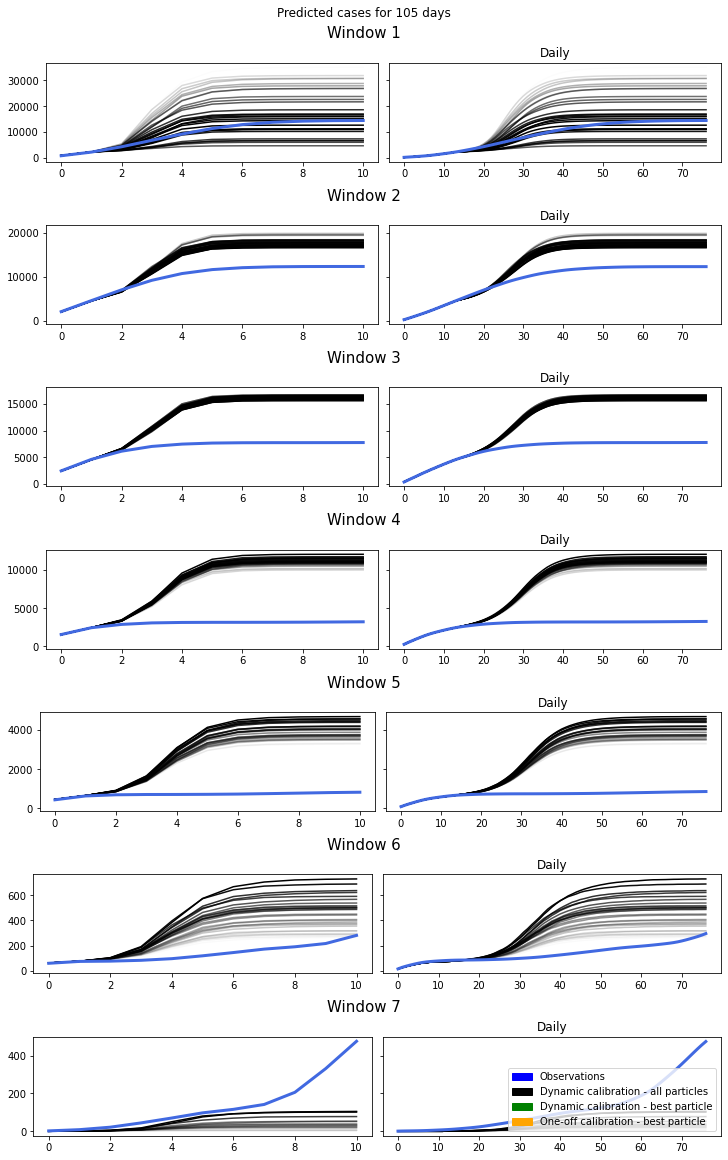

In [81]:
windows= list(window_lengths_dict.keys())[:-1]

# create 3x1 subplots
fig, axs = plt.subplots(nrows=len(windows_dict)-1, ncols=1, constrained_layout=True, figsize = (10,16))
fig.suptitle('Predicted cases for 105 days')

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

windows_i = 0
for row, subfig in enumerate(subfigs):
    # Get the run length associated with this window
    run_length = (windows_i + 1) *14
    # Create subfigure title
    subfig.suptitle('Window {}'.format(row+1), fontsize = 15)
    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2, sharey= True)   
    # Read the dictionary for this window
    this_windows_dict = windows_dict[windows[windows_i]]
    
    # Get the data from the one-off calibration for this window
    #oneoff_calib_best_params_modelled_weekly = oneoff_calib_best_params_modelled_weekly_dict["{}days".format(run_length)]
    #oneoff_calib_best_params_modelled_daily = oneoff_calib_best_params_modelled_daily_dict["{}days".format(run_length)]
    
    # Add 2 plots, one for daily, one for weekly
    for col, ax in enumerate(axs):
        
        # Plot model values
        _distance = np.array(this_windows_dict['distance'])  # Easier to do maths on np.array
        distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))
        
        # Plot weekly data
        if col == 0:
            x = range(len(this_windows_dict['sim'][0]))
            ### Dyanamic calibration
            # Plot model predictions for each particle in final population
            for i in range(len(this_windows_dict['summaries'])):
                ax.plot(x, this_windows_dict['sim'][i],
                color="black", alpha=1 - distance_norm[i]) # (1-x because high distance is bad)
            # Plot model predictions from best performing particle
            #dynamic_calib_best_params_modelled_weekly = dynamic_calib_best_params_modelled_weekly_dict[windows[windows_i]]
            #ax.plot(range(len(dynamic_calib_best_params_modelled_weekly)), dynamic_calib_best_params_modelled_weekly, label="BestParams - {}".format(window), color='green',
            #      linestyle='solid', linewidth =2.5)
            ### One-off calibration 
            # plot model predictions
#             ax.plot(x, oneoff_calib_best_params_modelled_weekly, label="sim", color="orange", linewidth = 3)     
            # Plot observations
            start_week = int((run_length/7)) -2
            end_week = int((ITERATIONS/7))+ start_week 
            print("start week: ", start_week, "end week: ", end_week)
            ax.plot(x, cases_devon_weekly_raw_values['OriginalCases'][start_week:end_week].cumsum().values, label="Observations", linewidth=3, color="royalblue")
#             #ax.plot(x, cases_devon_daily_summed_weekly[0:int((105/7))], label="Observations", linewidth=3, color="blue")
#             #ax.plot(x, cases_devon_daily_summed_weekly[0:int((105/7))], label="Observations", linewidth=3, color="blue")
#             #ax.set_title('Weekly')  
#         # PLot daily data
        elif col ==1:
            x = range(len(OpenCLRunner.get_cumulative_daily_infections(this_windows_dict['summaries'][1])))
            ### Dynamic calibration
            # Plot model predictions for each particle in final population            
            for i in range(len(this_windows_dict['summaries'])):
                ax.plot(x, OpenCLRunner.get_cumulative_daily_infections(this_windows_dict['summaries'][i]),
                color="black", alpha=1 - distance_norm[i]) # (1-x because high distance is bad)
            # Plot model predictions from best performing particle
            #dynamic_calib_best_params_modelled_daily = dynamic_calib_best_params_modelled_daily_dict[windows[windows_i]]
            #ax.plot(range(len(dynamic_calib_best_params_modelled_daily)), dynamic_calib_best_params_modelled_daily, label="BestParams - {}".format(window), color='green',
            #      linestyle='solid', linewidth =2.5)
            ### One-off calibration 
#             # plot model predictions
#             ax.plot(x, oneoff_calib_best_params_modelled_daily, label="sim", color="orange")
            # Plot observations
            start_day = run_length -14
            end_day = ITERATIONS  + start_day
            ax.plot(x, cases_devon_daily_raw_values['OriginalCases'][start_day:end_day].cumsum().values, label="Observations", linewidth = 3, color="royalblue")
            ax.set_title('Daily')
    
    # move on to next window
    windows_i = windows_i+1
    
# Create patches for legend 
black_patch = mpatches.Patch(color='black', label='Dynamic calibration - all particles')
blue_patch = mpatches.Patch(color='blue', label='Observations')
orange_patch = mpatches.Patch(color='orange', label='One-off calibration - best particle')
green_patch = mpatches.Patch(color='green', label='Dynamic calibration - best particle')
plt.legend(handles=[blue_patch, black_patch, green_patch,  orange_patch], loc="lower right", fontsize= 10)#, bbox_to_anchor=(2.2, 8.6)) 

['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7']

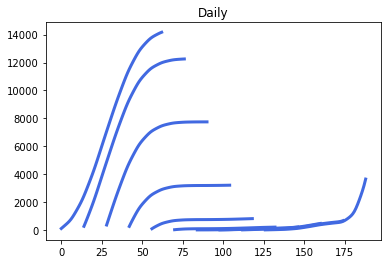

In [72]:
fig,ax= plt.subplots()

for windows_i in [0,1,2,3,4,5,6,7,8,9]:
    # Get the run length associated with this window
    run_length = (windows_i + 1) *14
    
    # Plot observations
    start_day = run_length -14
    end_day = 63  + start_day
    ax.plot(cases_devon_daily_raw_values['OriginalCases'][start_day:end_day].index, cases_devon_daily_raw_values['OriginalCases'][start_day:end_day].cumsum().values, label="Observations", linewidth = 3, color="royalblue")
    ax.set_title('Daily')
    
    # move on to next window
    windows_i = windows_i+1
    
windows= list(window_lengths_dict.keys())[:-1]
windows

##### Plot without all particles, just best-performing particle

In [ ]:
# create 3x1 subplots
fig, axs = plt.subplots(nrows=len(windows_dict)-1, ncols=1, constrained_layout=True, figsize = (10,16))
fig.suptitle('Predicted cases for 105 days')

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

windows_i = 0
for row, subfig in enumerate(subfigs):
    # Get the run length associated with this window
    run_length = (windows_i + 1) *14
    # Create subfigure title
    subfig.suptitle('Window {}'.format(row+1), fontsize = 15)
    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2, sharey= True)   
    # Read the dictionary for this window
    this_windows_dict = windows_dict[windows[windows_i]]
    
    # Get the data from the one-off calibration for this window
    oneoff_calib_best_params_modelled_weekly = oneoff_calib_best_params_modelled_weekly_dict["{}days".format(run_length)]
    oneoff_calib_best_params_modelled_daily = oneoff_calib_best_params_modelled_daily_dict["{}days".format(run_length)]
    
    # Add 2 plots, one for daily, one for weekly
    for col, ax in enumerate(axs):
        
        # Plot model values
        _distance = np.array(this_windows_dict['distance'])  # Easier to do maths on np.array
        distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))
        
        # Plot weekly data
        if col == 0:
            x = range(len(this_windows_dict['sim'][0]))
            ### Dyanamic calibration
            # Plot model predictions from best performing particle
            dynamic_calib_best_params_modelled_weekly = dynamic_calib_best_params_modelled_weekly_dict[windows[windows_i]]
            ax.plot(range(len(dynamic_calib_best_params_modelled_weekly)), dynamic_calib_best_params_modelled_weekly, label="BestParams - {}".format(window), color='green',
                  linestyle='solid', linewidth =2.5)
            ### One-off calibration 
            # plot model predictions
            ax.plot(x, oneoff_calib_best_params_modelled_weekly, label="sim", color="orange", linewidth = 3)     
            # Plot observations
            ax.plot(x, cases_devon_daily_summed_weekly[0:int((105/7))], label="Observations", linewidth=3, color="blue")
            ax.set_title('Weekly')  
        # PLot daily data
        elif col ==1:
            x = range(len(OpenCLRunner.get_cumulative_daily_infections(this_windows_dict['summaries'][1])))
            ### Dynamic calibration
            # Plot model predictions from best performing particle
            dynamic_calib_best_params_modelled_daily = dynamic_calib_best_params_modelled_daily_dict[windows[windows_i]]
            ax.plot(range(len(dynamic_calib_best_params_modelled_daily)), dynamic_calib_best_params_modelled_daily, label="BestParams - {}".format(window), color='green',
                  linestyle='solid', linewidth =2.5)
            ### One-off calibration 
            # plot model predictions
            ax.plot(x, oneoff_calib_best_params_modelled_daily, label="sim", color="orange")
            # Plot observations
            ax.plot(x, cases_devon_daily[0:105], label="Observations", linewidth = 3, color="blue")
            ax.set_title('Daily')
    
    # move on to next window
    windows_i = windows_i+1
    
# Create patches for legend 
plt.legend(handles=[blue_patch, black_patch, green_patch,  orange_patch], loc="lower right", fontsize= 10)#, bbox_to_anchor=(2.2, 8.6)) 